### 安装pip基础库

In [2]:
!pip install jax datasets flax onnx optax matplotlib

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 11.3 MB/s  0:00:00 eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 10.9 MB/s  0:00:00 eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


### 介绍一下JAX Flax生态
#### 1.函数式编程
    简单的说，函数是第一等公民
函数与其他数据类型处于平等地位，我们可以将函数赋值给变量，也可以将其作为参数传入其他函数，将它们存储在其他数据结构（如 dicts）中，并将它们作为其他函数的返回值。
##### 函数作为对象
请看下面的代码：
可以看到，我们将函数作为对象赋值给变量，然后调用了这个变量。

In [17]:
def helloworld():
    print("Hello, world!")

test = helloworld
test()

Hello, world!


#### 将对象作为函数
将一个Object直接调用，之需要实现一个叫__call__的方法
如下面代码所示：

In [21]:
class Test:
    def __init__(self,name):
        self.name = name
    def __call__(self,age):
        print(f"My name is {self.name},I am {age} years old.")
p = Test("Kemna")
p(19)

My name is Kemna,I am 19 years old.


#### 函数用于数据结构
函数也可以用在其他数据结构里面
看下面的代码：

In [ ]:
mapping = {
    0: helloworld,
    1:p(10)
}

x = mapping[1]
y = mapping[0]

print(x)
print(y)

My name is Kemna,I am 10 years old.
None
<function helloworld at 0x7f74943f16c0>


接下来我们以MNIST数据集为例，介绍如何使用JAX生态进行训练

### 导入mnist数据集

['train', 'test']
Label: 5
image shape: (28, 28)


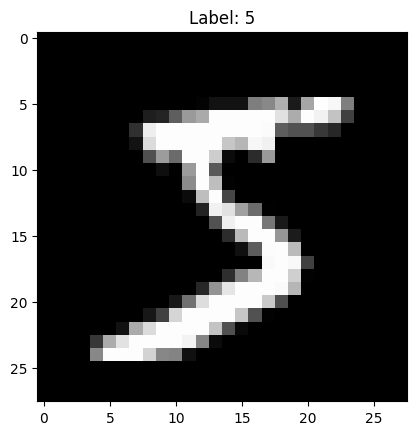

In [5]:
from datasets import load_dataset,get_dataset_split_names
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
dataset = load_dataset("ylecun/mnist")
# 在huggingface中，这个数据集被切割成了三个部分
spilts = get_dataset_split_names("ylecun/mnist")
print(spilts)
#查看一个样本
train_data = dataset["train"]
image = train_data[0]["image"]
label = train_data[0]["label"]
#显示图像
print(f"Label: {label}")
image = jnp.array(image)
print(f"image shape: {image.shape}")
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

### 定义神经网络
导入的是一个简单的神经网络：cnn

In [6]:
from flax import linen as nn
class CNN(nn.Module):
  """A simple CNN model."""
  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

其模型层级结构可以这么查看

In [ ]:
import jax
import jax.numpy as jnp  # JAX NumPy
cnn = CNN()
print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 28, 28, 1)),
                   compute_flops=True, compute_vjp_flops=True))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs     ┃ outputs   ┃ flops   ┃ vjp_flops ┃ params     ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩
│         │ CNN    │ float32[1… │ float32[… │ 8708106 │ 26957556  │            │
├─────────┼────────┼────────────┼───────────┼─────────┼───────────┼────────────┤
│ Conv_0  │ Conv   │ float32[1… │ float32[… │ 455424  │ 1341472   │ bias:      │
│         │        │            │           │         │           │ float32[3… │
│         │        │            │           │         │           │ kernel:    │
│         │        │            │           │         │           │ float32[3… │
│         │        │            │           │         │           │            │
│         │        │            │           │         │           │ 320 (1.3   │
│         │        │       

### 计算参数

In [ ]:
#计算参数
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

### 训练状态创建

In [ ]:
#训练状态
class TrainState(train_state.TrainState):
  metrics: metrics

def create_train_state(module, rng, learning_rate, momentum):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

NameError: name 'train_state' is not defined

### 定义训练过程

In [24]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

### 设置随机种子/训练轮次/batch_size

In [ ]:
num_epochs = 10
batch_size = 32
key = random.PRNGKey(42)
learning_rate = 1e-4
momentum = 0.9
state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.
num_steps_per_epoch = train_data.cardinality().numpy() // num_epochs
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}


## 定义训练循环

In [ ]:
for step,batch in enumerate(train_data):
  #convert the image and label to jax.jnp.array
  image = jnp.array(batch['image'])
  if image.ndim == 2:
    image = image[..., None]  # (28, 28, 1)
  image = image[None, ...]      # (1, 28, 28, 1)
  label = jnp.array([batch['label']])           # shape: (1,)
  batch = {'image': image, 'label': label}
  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_data:
        #convert the image and label to jax.jnp.array
      image = jnp.array(test_batch['image'])
      if image.ndim == 2:
        image = image[..., None]  # (28, 28, 1)
      image = image[None, ...]      # (1, 28, 28, 1)
      label = jnp.array([test_batch['label']])           # shape: (1,)
      test_batch = {'image': image, 'label': label}
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

### 指标可视化

In [ ]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

### 完整训练代码

In [20]:
from datasets import load_dataset,get_dataset_split_names
from flax import linen as nn
import matplotlib.pyplot as plt
import jax.random as random
from flax import struct 
from flax.training import train_state 
from clu import metrics
import jax.numpy as jnp
import optax
import jax

#定义神经网络
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

#计算参数
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state
#训练状态
class TrainState(train_state.TrainState):
  metrics: metrics

def create_train_state(module, rng, learning_rate, momentum):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())
#训练过程
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state


#定义必需数据
dataset = load_dataset("ylecun/mnist")
train_data = dataset["train"]
test_data = dataset["test"]
num_epochs = 10
batch_size = 32
init_rng = random.PRNGKey(42)
learning_rate = 1e-4
momentum = 0.9
model = CNN()
state = create_train_state(model, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.
num_steps_per_epoch = len(train_data) // num_epochs
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}


for step,batch in enumerate(train_data):
  #convert the image and label to jax.jnp.array
  image = jnp.array(batch['image'])
  if image.ndim == 2:
    image = image[..., None]  # (28, 28, 1)
  image = image[None, ...]      # (1, 28, 28, 1)
  label = jnp.array([batch['label']])           # shape: (1,)
  batch = {'image': image, 'label': label}
  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_data:
        #convert the image and label to jax.jnp.array
      image = jnp.array(test_batch['image'])
      if image.ndim == 2:
        image = image[..., None]  # (28, 28, 1)
      image = image[None, ...]      # (1, 28, 28, 1)
      label = jnp.array([test_batch['label']])           # shape: (1,)
      test_batch = {'image': image, 'label': label}
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.20214499533176422, accuracy: 94.73333740234375
test epoch: 1, loss: 0.19286806881427765, accuracy: 93.55999755859375
train epoch: 2, loss: 0.08750319480895996, accuracy: 97.68333435058594
test epoch: 2, loss: 0.14306960999965668, accuracy: 95.2300033569336
train epoch: 3, loss: 0.06927433609962463, accuracy: 98.03333282470703
test epoch: 3, loss: 0.08870075643062592, accuracy: 97.12999725341797
train epoch: 4, loss: 0.05574699491262436, accuracy: 98.44999694824219
test epoch: 4, loss: 0.09710337221622467, accuracy: 96.86000061035156
train epoch: 5, loss: 0.05529126152396202, accuracy: 98.41667175292969
test epoch: 5, loss: 0.06792223453521729, accuracy: 97.82999420166016
train epoch: 6, loss: 0.05345893278717995, accuracy: 98.58333587646484
test epoch: 6, loss: 0.05715334415435791, accuracy: 98.1199951171875
train epoch: 7, loss: 0.052290190011262894, accuracy: 98.71666717529297
test epoch: 7, loss: 0.06417568773031235, accuracy: 97.93000030517578
train epoch: 8

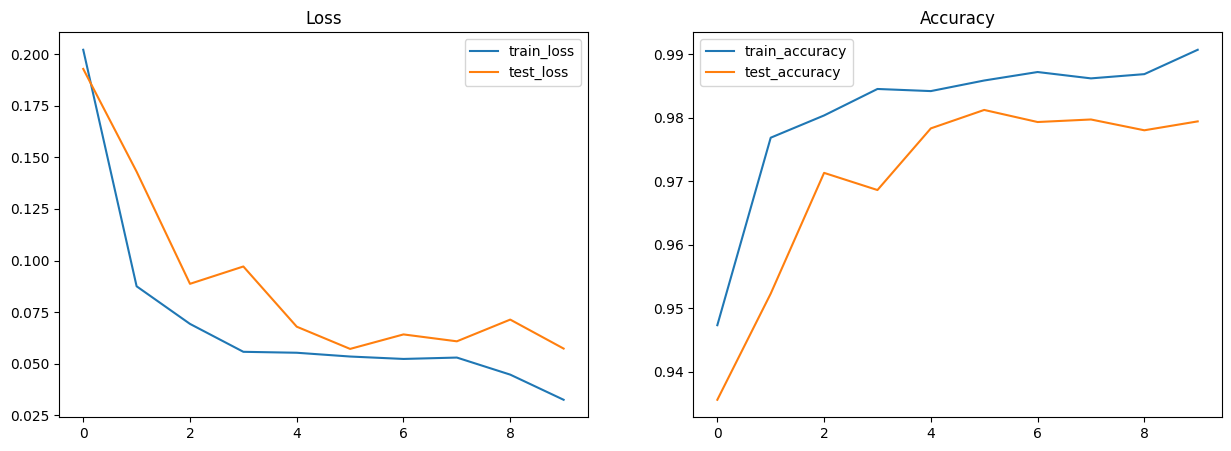

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()